In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
'''
** Dataprep(filepath, test_ratio, z_cut) **
Inputs:
- filepath: path to the pre-processed AFM data file, in .npz format
- test_ratio: the ratio between the total number of approach curve data and the number of the approach curve data used in the validation set
- z_cut: the z point at after which the AFM data is truncated and tossed


Outputs:
- train_dataset: dataset corresponding to the training set
- test_dataset: dataset corresponding to the test set
- train: training set
- test: test set
'''

def DataPrep(filepath, test_ratio = 0.1, z_cut = 5): # the filepath must point to pre-processed AFM datafile, in .npz format
    # load the npz file
    dataset = np.load(filepath)

    raw_dataset = dataset['raw'] # Lock-in raw data, [z, Amp(V), Phas(rad)] format
    mech_dataset = dataset['mech'] # Mechanical Amp, Phas,[z, Amp(V), Phas(rad)] format
    imin_dataset = dataset['imin'] # array index of the turning point : Appoach is from 0 ~ imin, Retract is from imin ~ end

    # Resonance curve fitting parameters
    Q_dataset = dataset['Q']
    w_dataset = dataset['w']
    w0_dataset = dataset['w0']
    I0_dataset = dataset['I0']
    C0C_dataset = dataset['C0C']

    E_dataset = dataset['E'] # Dissipated energy, normalized by kA0^2
    kint_dataset = dataset['kint'] # k_int, normalized by k
    bint_dataset = dataset['bint'] # b_int, normalized by k

    Fk_dataset = dataset['Fk'] # <F_k> = kA, normalized by kA0
    Fb_dataset = dataset['Fb'] # <F_b> = bwA, normalized by kA0

    filename_dataset = dataset['filename'] # filename

    N = Q_dataset.size
    N_test = int(N*test_ratio)

    print('Number of test samples : %d' %(N_test))
    print('Number of training samples : %d' %(N - N_test))

    sample_index = np.arange(N)
    np.random.shuffle(sample_index) # shuffle the input data

    train = np.empty([1,9]) # z, amp, phas, w/w0, Q
    test = np.empty([1,9]) 
    train_dataset = []
    test_dataset = []
    
    for i in range(N):
        index = sample_index[i]
    
        imin = imin_dataset[index]
        ww0_array = np.ones((imin, 1))*w_dataset[index]/w0_dataset[index] # Array of w/w0
        Q_array = np.ones((imin, 1))*Q_dataset[index]
        
        mech_dataset[index][:, 1] = mech_dataset[index][:, 1]/mech_dataset[index][0, 1] # Normalize the mechanical amplitude
        
        data = np.c_[mech_dataset[index][0:imin, :], ww0_array, Q_array]
        
        # Truncate the data for z > z_cut
        z = raw_dataset[index][0:imin, 0]
        cut_index = z < z_cut
        data = data[cut_index, :]
        
        if i < N_test:   
            test = np.r_[test, data]
        else:
            train = np.r_[train, data]

    test = test[1:, :] # Discard the first row, which is randomly initialized by np.empty
    train = train[1:, :]
    
    test_index = sample_index[0:N_test]
    train_index = sample_index[N_test:]
    
    keys = np.array(list(dataset.keys()))
    values = np.array(list(dataset.values()))
    print(values.shape)
    
    train_dataset = dict(zip(keys, values[:, train_index]))
    test_dataset = dict(zip(keys, values[:, test_index]))
    
    return [train_dataset, test_dataset, train, test]

Number of test samples : 31
Number of training samples : 279
(14, 310)


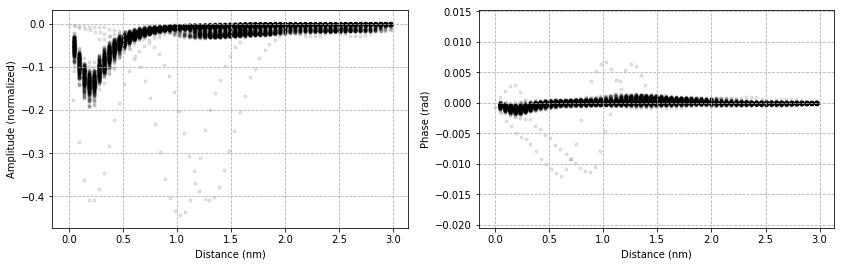

In [28]:
# filepath to the reformatted data file
filepath = 'C:\\Users\\user\\OneDrive - SNU\\Jhe Lab\\Projects\\Current\\1. AFM Contact Point Detection\\DohyunBest_best_deriv2.npz'
test_ratio = 0.1
z_cut = 3

train_dataset, test_dataset, train, test = DataPrep(filepath, test_ratio, z_cut)

# Graph the training set
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
kwargs = {'c':'k', 'marker':'.', 'alpha':0.1}

ax1.scatter(train[:,0], train[:, 3], **kwargs)
ax1.set_xlabel('Distance (nm)')
ax1.set_ylabel('Amplitude (normalized)')
ax1.grid(ls = '--')

ax2.scatter(train[:,0], train[:, 4], **kwargs)
ax2.set_xlabel('Distance (nm)')
ax2.set_ylabel('Phase (rad)')
ax2.grid(ls = '--')


Text(0.5, 1.0, 'Phase space of the Training dataset (colormap = z)')

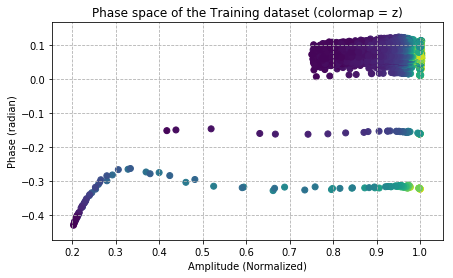

In [29]:
fig = plt.figure(figsize = (7, 4))
ax = fig.add_subplot(111)

ax.scatter(train[:,1], train[:,2], c = train[:,0])
ax.grid(ls = '--')
ax.set_xlabel('Amplitude (Normalized)')
ax.set_ylabel('Phase (radian)')
ax.set_title('Phase space of the Training dataset (colormap = z)')

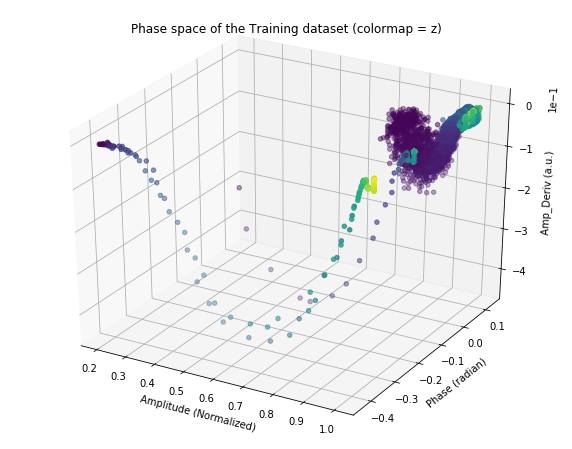

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train[:,1], train[:,2], train[:,3], c = train[:,0])

ax.grid(ls = '--')
ax.set_xlabel('Amplitude (Normalized)', labelpad = 5.5)
ax.set_ylabel('Phase (radian)', labelpad = 5.5)
ax.set_zlabel('Amp_Deriv (a.u.)', labelpad = 5.5)
ax.ticklabel_format(axis = 'z', style = 'sci', scilimits = (0,0))
ax.set_title('Phase space of the Training dataset (colormap = z)', pad = 9)
ax.grid(ls = '--')


**Perform k-means clustering to verify if there is well-defined centriod (preferably with k=3) in the 4(+2)D phase space**

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [22]:
cluster = np.empty(train[:,1:].shape)
def Normalize(array):
    array = array - np.amin(array)
    array = array/np.amax(array)
    return array

_, n_col = cluster.shape
for i in range(n_col):
    cluster[:,i] = Normalize(train[:,i+1])

print(cluster)

[[0.99477177 0.89222961 0.99587313 0.64330149 0.67472844 0.78939485]
 [0.99438528 0.89140853 0.9951049  0.64301438 0.67472844 0.78939485]
 [0.99562707 0.89271819 0.99574831 0.64217146 0.67472844 0.78939485]
 ...
 [0.81830074 0.87358073 0.6930002  0.5648691  0.89437788 0.49434358]
 [0.76048534 0.87109084 0.73184982 0.58366465 0.89437788 0.49434358]
 [0.71649028 0.86546675 0.81914392 0.60134706 0.89437788 0.49434358]]


In [8]:
n = 4
kmeans = KMeans(n_clusters = n)
kmeans.fit(cluster)

print(kmeans.cluster_centers_)
cluster_labels = kmeans.fit_predict(cluster)

[[0.97241172 0.92027877 0.97527273 0.64778431]
 [0.8360894  0.91775959 0.77092254 0.60555462]
 [0.16149734 0.17420402 0.64081263 0.48207934]
 [0.9516261  0.3279175  0.90345412 0.64718772]]


In [9]:
print(cluster_labels.shape)
print(train.shape)

(17846,)
(17846, 7)


Text(0.5, 1.0, 'k means clustering result (k=4)')

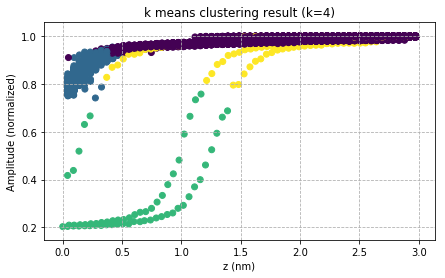

In [10]:
fig = plt.figure(figsize = (7, 4))
ax = fig.add_subplot(111)

ax.scatter(train[:,0], train[:,1], c = cluster_labels)
ax.grid(ls = '--')
ax.set_xlabel('z (nm)')
ax.set_ylabel('Amplitude (normalized)')
ax.set_title('k means clustering result (k=4)')

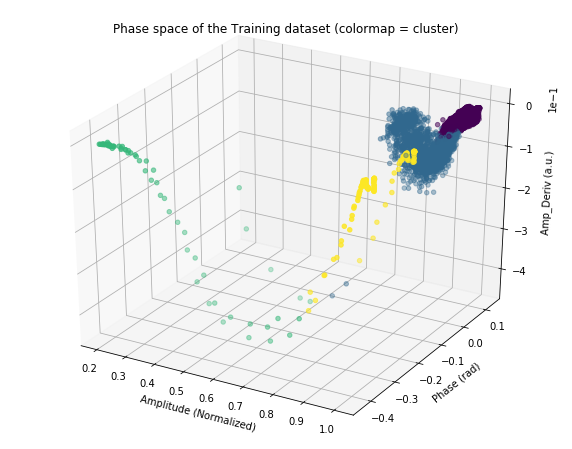

In [11]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train[:,1], train[:,2], train[:,3], c = cluster_labels)

ax.grid(ls = '--')
ax.set_xlabel('Amplitude (Normalized)', labelpad = 5.5)
ax.set_ylabel('Phase (rad)', labelpad = 5.5)
ax.set_zlabel('Amp_Deriv (a.u.)', labelpad = 5.5)
ax.ticklabel_format(axis = 'z', style = 'sci', scilimits = (0,0))
ax.set_title('Phase space of the Training dataset (colormap = cluster)', pad = 9)
ax.grid(ls = '--')


**Perform t-SNE on the dataset**

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17846 samples in 0.091s...
[t-SNE] Computed neighbors for 17846 samples in 1.199s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17846
[t-SNE] Computed conditional probabilities for sample 2000 / 17846
[t-SNE] Computed conditional probabilities for sample 3000 / 17846
[t-SNE] Computed conditional probabilities for sample 4000 / 17846
[t-SNE] Computed conditional probabilities for sample 5000 / 17846
[t-SNE] Computed conditional probabilities for sample 6000 / 17846
[t-SNE] Computed conditional probabilities for sample 7000 / 17846
[t-SNE] Computed conditional probabilities for sample 8000 / 17846
[t-SNE] Computed conditional probabilities for sample 9000 / 17846
[t-SNE] Computed conditional probabilities for sample 10000 / 17846
[t-SNE] Computed conditional probabilities for sample 11000 / 17846
[t-SNE] Computed conditional probabilities for sample 12000 / 17846
[t-SNE] Computed conditional probabilities for sa

Text(0.5, 1.0, 't-SNE result of the dataset')

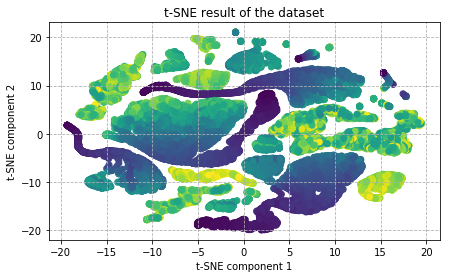

In [30]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, perplexity = 40, verbose = 1, n_iter = 350)
tsne_results = tsne.fit_transform(train[:,1:])

fig = plt.figure(figsize = (7, 4))
ax = fig.add_subplot(111)

ax.scatter(tsne_results[:,0], tsne_results[:,1], c = train[:,0])
ax.grid(ls = '--')
ax.set_xlabel('t-SNE component 1')
ax.set_ylabel('t-SNE component 2')
ax.set_title('t-SNE result of the dataset')